<a href="https://colab.research.google.com/github/Roshanyadav06/ML-/blob/main/tumour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Copy kaggle.json from your Google Drive to ~/.kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/  # modify path if needed
!chmod 600 ~/.kaggle/kaggle.json


Mounted at /content/drive


In [2]:
!pip install -q kagglehub

import kagglehub
import os

# Download dataset using kagglehub
path = kagglehub.dataset_download("thilak02/breast-cancer-detection-using-thermography")

print("Dataset path:", path)
print("Folders inside dataset:", os.listdir(path))
print("Dataset path:", path)
print("Folders in dataset:", os.listdir(path))



100%|██████████| 1.39M/1.39M [00:00<00:00, 102MB/s]

Extracting files...
Dataset path: /root/.cache/kagglehub/datasets/thilak02/breast-cancer-detection-using-thermography/versions/1
Folders inside dataset: ['BCD_Dataset']
Dataset path: /root/.cache/kagglehub/datasets/thilak02/breast-cancer-detection-using-thermography/versions/1
Folders in dataset: ['BCD_Dataset']


In [3]:
import numpy as np
import cv2
import os

IMG_SIZE = 128
X, y = [], []

# Use the correct nested path
data_path = os.path.join(path, "BCD_Dataset")

for label in os.listdir(data_path):
    folder_path = os.path.join(data_path, label)
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                X.append(img)
                y.append(0 if "normal" in label.lower() else 1)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = np.array(y)

print("Data loaded successfully. Shape:", X.shape)


Data loaded successfully. Shape: (362, 128, 128, 1)


In [4]:
print("Total samples:", len(X))


Total samples: 362


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (289, 128, 128, 1)
Test shape: (73, 128, 128, 1)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn()
cnn_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,937,985 (49.35 MB)

 Trainable params: 12,937,985 (49.35 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = cnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    verbose=1
)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 722ms/step - accuracy: 0.5617 - loss: 1.2533 - val_accuracy: 0.4483 - val_loss: 1.0191
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 646ms/step - accuracy: 0.7036 - loss: 0.6033 - val_accuracy: 0.8448 - val_loss: 0.3583
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 794ms/step - accuracy: 0.8071 - loss: 0.4538 - val_accuracy: 0.8621 - val_loss: 0.3951
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 692ms/step - accuracy: 0.8465 - loss: 0.3704 - val_accuracy: 0.8448 - val_loss: 0.3679
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 661ms/step - accuracy: 0.9151 - loss: 0.2955 - val_accuracy: 0.8448 - val_loss: 0.3726
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 567ms/step - accuracy: 0.8634 - loss: 0.3690 - val_accuracy: 0.8621 - val_loss: 0.3177
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 672ms/step - accuracy: 0.8316 - loss: 0.3305 - val_accuracy: 0.8448 - val_loss: 0.2975
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 685ms/step - accuracy: 0.9021 - loss: 0.2583 - val_accur

In [8]:
from sklearn.metrics import classification_report

loss, acc = cnn_model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.4f}")

# Predict and print classification report
y_pred = (cnn_model.predict(X_test) > 0.5).astype("int32")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.9443 - loss: 0.3854

Test Accuracy: 0.9589
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        33
           1       0.97      0.95      0.96        40

    accuracy                           0.96        73
   macro avg       0.96      0.96      0.96        73
weighted avg       0.96      0.96      0.96        73



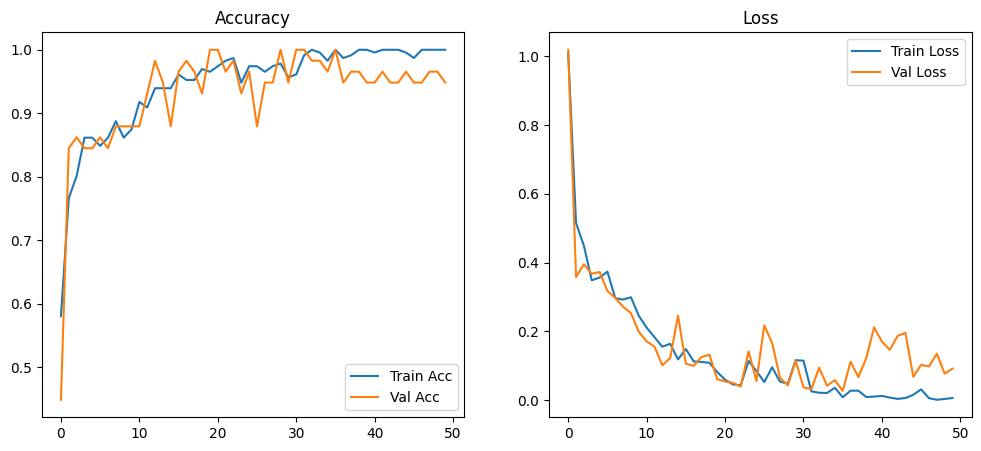

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()
